## Pumpkin Pricing Per Bushel, by City

Load up required libraries and dataset. Convert the data to a dataframe containing a subset of the data: 

- Only get pumpkins priced by the bushel
- Convert the date to a month
- Calculate the price to be an average of high and low prices
- Convert the price to reflect the pricing by bushel quantity

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pumpkins = pd.read_csv('../../data/US-pumpkins.csv')

pumpkins.head()


,City Name,Type,Package,Variety,Sub Variety,Grade,Date,Low Price,High Price,Mostly Low,...,Unit of Sale,Quality,Condition,Appearance,Storage,Crop,Repack,Trans Mode,Unnamed: 24,Unnamed: 25
0,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,4/29/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
1,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,5/6/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
2,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
3,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
4,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,11/5/16,90.0,100.0,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN


In [19]:
from sklearn.preprocessing import LabelEncoder

pumpkins = pumpkins[pumpkins['Package'].str.contains('bushel', case=True, regex=True)]

new_columns = ['Package', 'Variety', 'City Name', 'Month', 'Low Price', 'High Price', 'Date']

pumpkins = pumpkins.drop([c for c in pumpkins.columns if c not in new_columns], axis=1)

price = (pumpkins['Low Price'] + pumpkins['High Price']) / 2

month = pd.DatetimeIndex(pumpkins['Date']).month

new_pumpkins = pd.DataFrame({'Month': month, 'Variety': pumpkins['Variety'], 'City': pumpkins['City Name'], 'Package': pumpkins['Package'], 'Low Price': pumpkins['Low Price'],'High Price': pumpkins['High Price'], 'Price': price})

new_pumpkins.loc[new_pumpkins['Package'].str.contains('1 1/9'), 'Price'] = price/1.1

new_pumpkins.loc[new_pumpkins['Package'].str.contains('1/2'), 'Price'] = price*2

new_pumpkins.iloc[:, 0:-1] = new_pumpkins.iloc[:, 0:-1].apply(LabelEncoder().fit_transform)
new_pumpkins.iloc[:, 0:-1] = new_pumpkins.iloc[:, 0:-1].apply(LabelEncoder().fit_transform)


new_pumpkins.head()


,Month,Variety,City,Package,Low Price,High Price,Price
70,1,3,1,0,5,3,13.636364
71,1,3,1,0,10,7,16.363636
72,2,3,1,0,10,7,16.363636
73,2,3,1,0,9,6,15.454545
74,2,3,1,0,5,3,13.636364


A basic scatterplot reminds us that we only have month data from August through December. We probably need more data to be able to draw conclusions in a linear fashion.

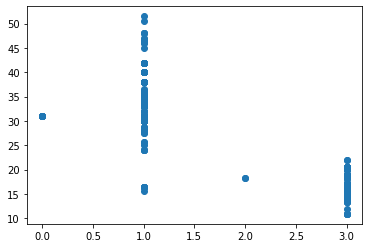

In [20]:
import matplotlib.pyplot as plt
plt.scatter('Variety','Price',data=new_pumpkins)


In [21]:
print(new_pumpkins['Variety'].corr(new_pumpkins['Price']))

-0.8634790400214403


In [22]:

new_pumpkins.dropna(inplace=True)
new_pumpkins.info()




<class 'pandas.core.frame.DataFrame'>
Int64Index: 415 entries, 70 to 1742
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Month       415 non-null    int64  
 1   Variety     415 non-null    int64  
 2   City        415 non-null    int64  
 3   Package     415 non-null    int64  
 4   Low Price   415 non-null    int64  
 5   High Price  415 non-null    int64  
 6   Price       415 non-null    float64
dtypes: float64(1), int64(6)
memory usage: 25.9 KB


In [23]:
# create new dataframe 
new_columns = ['Variety', 'Price']
ml_pumpkins = new_pumpkins.drop([c for c in new_pumpkins.columns if c not in new_columns], axis='columns')

ml_pumpkins


,Variety,Price
70,3,13.636364
71,3,16.363636
72,3,16.363636
73,3,15.454545
74,3,13.636364
...,...,...
1738,1,30.000000
1739,1,28.750000
1740,1,25.750000
1741,1,24.000000


In [30]:
X = ml_pumpkins.values[:, :1]
y = ml_pumpkins.values[:, 1:2]


In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

pred = lin_reg.predict(X_test)

accuracy_score = lin_reg.score(X_train,y_train)
print('Model Accuracy: ', accuracy_score)

# The coefficients
print('Coefficients: ', lin_reg.coef_)
# The mean squared error
print('Mean squared error: ',
      mean_squared_error(y_test, pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: ',
      r2_score(y_test, pred)) 

Model Accuracy:  0.7327987875929955
Coefficients:  [[-8.54296764]]
Mean squared error:  23.443815358076087
Coefficient of determination:  0.7802537224707632


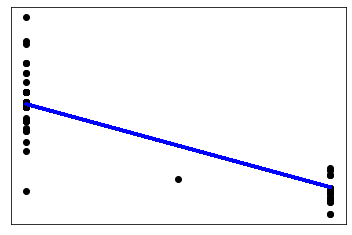

In [26]:

plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

